In [18]:
# ===========================
#   1. IMPORTS AND SETUP
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels, pmdarima, etc.
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# pmdarima for automated ARIMA
#import pmdarima as pm

# Neural Network (Keras MLP) – for Part 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# For ignoring harmless warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Matplotlib settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'figure.dpi': 100})


In [19]:
# ===========================
#   2. LOAD DATA
# ===========================
# 2.1 Johnson & Johnson Data
jj_df = pd.read_csv("jj.csv")
# If "jj.csv" has columns like: Date, Sales
# Adjust the code below to match the actual column names in jj.csv

# Sometimes there's a 'time' or 'quarter' column.
# Let's assume there's an index column "date" or "time"
# If there's no date/time column, consider just using a numeric index
# For demonstration, let's create a date range. Adjust as needed.
jj_df.columns = ["date", "sales"]  # example rename
jj_df["date"] = pd.to_datetime(jj_df["date"])
jj_df.set_index("date", inplace=True)


In [21]:
print("Johnson & Johnson data:")
display(jj_df.head())

Johnson & Johnson data:


,sales
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [22]:
# 2.2 Amazon Data
amzn_df = pd.read_csv("AMZN.csv")
# Typical columns might be: Date, Open, High, Low, Close, Volume, ...
# Adjust these lines to fit your actual CSV.

In [23]:
amzn_df.columns = ["date", "open", "high", "low", "close", "adj_close", "volume"]  # example
amzn_df["date"] = pd.to_datetime(amzn_df["date"])
amzn_df.set_index("date", inplace=True)


In [24]:
print("Amazon data:")
display(amzn_df.head())

Amazon data:


,open,high,low,close,adj_close,volume
date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


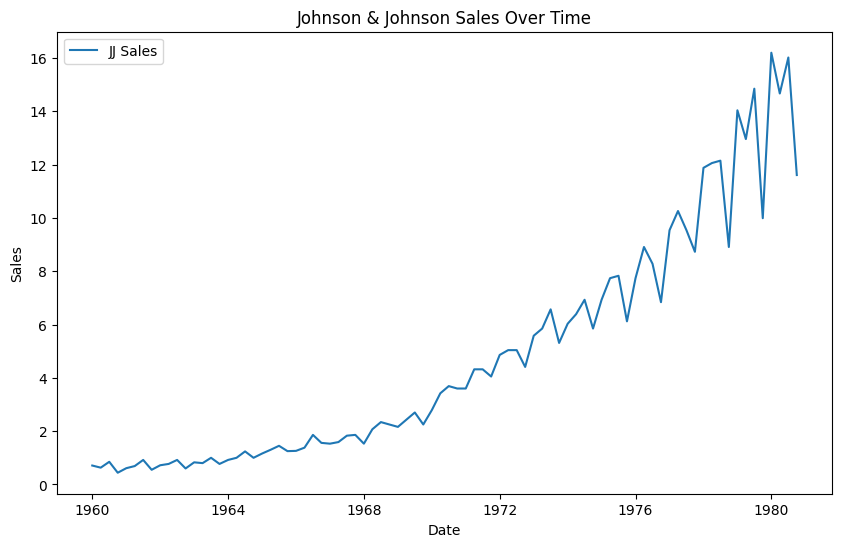

In [25]:
# ===========================
#   3. EXPLORE THE DATA
# ===========================
# 3.1 Johnson & Johnson

plt.figure()
plt.plot(jj_df["sales"], label="JJ Sales")
plt.title("Johnson & Johnson Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

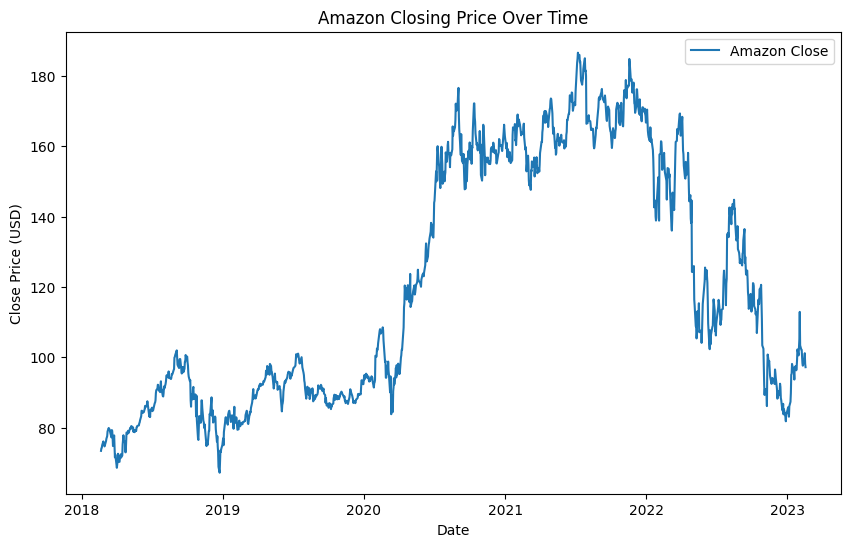

In [26]:
# 3.2 Amazon Closing Price
plt.figure()
plt.plot(amzn_df["close"], label="Amazon Close")
plt.title("Amazon Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [27]:
# ===========================
#   4. STATIONARITY CHECKS
# ===========================
# We'll illustrate for J&J data first:

jj_series = jj_df["sales"].astype(float)

# 4.1 Augmented Dickey-Fuller (ADF) Test
def adf_check(series, title=""):
    """
    Perform ADF stationarity test and print results.
    """
    print(f"Results of Dickey-Fuller Test for: {title}")
    result = adfuller(series, autolag='AIC')
    labels = ["ADF test statistic","p-value","# lags used","# observations"]
    out = pd.Series(result[0:4], index=labels)
    for key,val in result[4].items():
        out[f"critical value ({key})"] = val
    print(out.to_string(), "\n")

adf_check(jj_series, title="JJ Sales (raw)")

Results of Dickey-Fuller Test for: JJ Sales (raw)
ADF test statistic       2.742017
p-value                  1.000000
# lags used             11.000000
# observations          72.000000
critical value (1%)     -3.524624
critical value (5%)     -2.902607
critical value (10%)    -2.588679 



In [28]:
# We consider log or diff transformations, etc.
# For demonstration:
import numpy as np
jj_log = np.log(jj_series)
adf_check(jj_log, title="JJ Sales (log)")

# If needed, we difference (d=1):
jj_log_diff = jj_log.diff().dropna()
adf_check(jj_log_diff, title="JJ Sales (log diff)")

# Similarly, we can do this for the Amazon close price:
amzn_close = amzn_df["close"].astype(float)

adf_check(amzn_close, title="AMZN Close (raw)")

amzn_log = np.log(amzn_close + 1e-9)  # tiny offset if close can be zero
adf_check(amzn_log, title="AMZN Close (log)")

amzn_log_diff = amzn_log.diff().dropna()
adf_check(amzn_log_diff, title="AMZN Close (log diff)")


Results of Dickey-Fuller Test for: JJ Sales (log)
ADF test statistic      -0.804057
p-value                  0.817927
# lags used              4.000000
# observations          79.000000
critical value (1%)     -3.515977
critical value (5%)     -2.898886
critical value (10%)    -2.586694 

Results of Dickey-Fuller Test for: JJ Sales (log diff)
ADF test statistic      -4.317044
p-value                  0.000415
# lags used              5.000000
# observations          77.000000
critical value (1%)     -3.518281
critical value (5%)     -2.899878
critical value (10%)    -2.587223 

Results of Dickey-Fuller Test for: AMZN Close (raw)
ADF test statistic        -1.657809
p-value                    0.452971
# lags used                0.000000
# observations          1258.000000
critical value (1%)       -3.435559
critical value (5%)       -2.863840
critical value (10%)      -2.567995 

Results of Dickey-Fuller Test for: AMZN Close (log)
ADF test statistic        -1.784832
p-value              

<Figure size 1000x600 with 0 Axes>

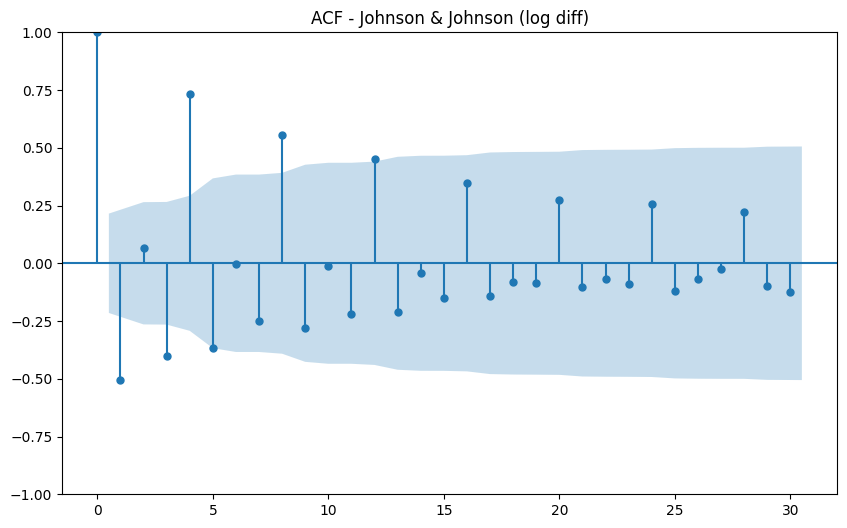

<Figure size 1000x600 with 0 Axes>

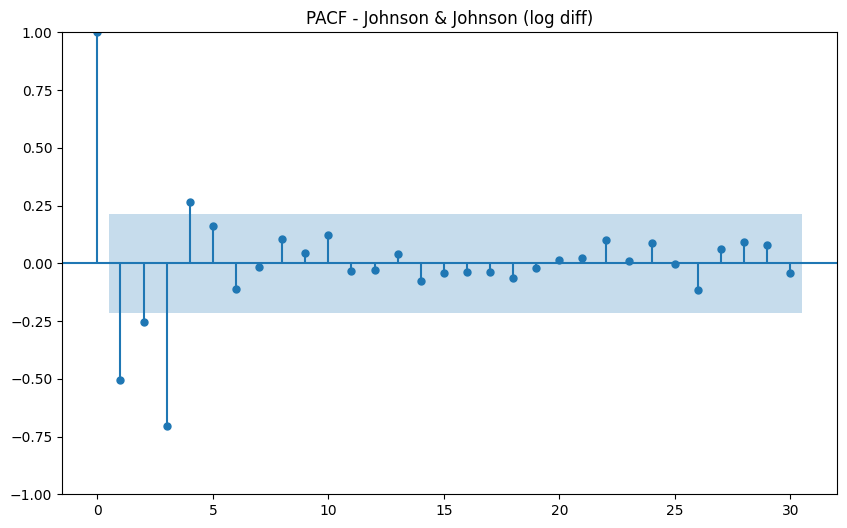

In [29]:
# ===========================
#   5. ACF AND PACF
# ===========================
# We typically look at the differenced series if it's not stationary
plt.figure()
plot_acf(jj_log_diff, lags=30)
plt.title("ACF - Johnson & Johnson (log diff)")
plt.show()

plt.figure()
plot_pacf(jj_log_diff, lags=30, method='ywm')
plt.title("PACF - Johnson & Johnson (log diff)")
plt.show()

In [30]:
# ===========================
#   6. ARIMA MODELING (Example with J&J)
# ===========================
# We will do two approaches: a manual grid search, and then pmdarima's auto_arima.

# 6.1 Train-Test Split
# For illustration, let's hold out the last N data points as test set
# Or you can do cross validation. Adjust as necessary.
n_test = 12  # e.g. 12 months or 12 quarters, depending on data
jj_train = jj_log_diff.iloc[:-n_test]
jj_test = jj_log_diff.iloc[-n_test:]

print("Train end date:", jj_train.index[-1])
print("Test start date:", jj_test.index[0])

Train end date: 1977-10-01 00:00:00
Test start date: 1978-01-01 00:00:00


In [31]:
# 6.2 Manual Grid Search for ARIMA(p, d, q)
import itertools

p_values = range(0, 5)
d_values = [0, 1]  # we already differenced once externally, but we can try d=1 inside the model
q_values = range(0, 5)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(jj_train, order=(p,d,q))
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = (p,d,q)
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA order: {best_order} AIC: {best_aic}")
print(best_model.summary())


Best ARIMA order: (4, 0, 0) AIC: -121.80717127310848
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   71
Model:                 ARIMA(4, 0, 0)   Log Likelihood                  66.904
Date:                Sat, 12 Apr 2025   AIC                           -121.807
Time:                        18:04:34   BIC                           -108.231
Sample:                             0   HQIC                          -116.408
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0390      0.005      8.090      0.000       0.030       0.048
ar.L1         -0.6398      0.122     -5.248      0.000      -0.879      -0.401

In [32]:
# ===========================
#   7. FIT FINAL MODEL AND FORECAST (Example: J&J)
# ===========================
# We can take whichever approach we prefer (the best_model or auto_arima).
# Let's pick the best_model from manual approach:

final_model = ARIMA(jj_log_diff, order=best_order)
final_model_fit = final_model.fit()
print(final_model_fit.summary())

# Forecast next 24 steps (for instance).
# The original assignment mentions 24 months or 24 periods.
forecast_steps = 24

# We'll use get_forecast.
forecast_result = final_model_fit.get_forecast(steps=forecast_steps)
mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Because we fitted on differenced log data, we must invert the differencing + exp
# In practice, the inversion can be tricky. You might want to do it cumulatively.
# As a simpler demonstration, we'll just show the differenced forecast for illustration.

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   83
Model:                 ARIMA(4, 0, 0)   Log Likelihood                  80.624
Date:                Sat, 12 Apr 2025   AIC                           -149.248
Time:                        18:04:39   BIC                           -134.735
Sample:                             0   HQIC                          -143.417
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0384      0.004      9.575      0.000       0.031       0.046
ar.L1         -0.6830      0.113     -6.040      0.000      -0.905      -0.461
ar.L2         -0.6099      0.117     -5.206      0.0

**3. Build and Train the Neural Network**
We use Keras (from TensorFlow) to build a simple feedforward model.

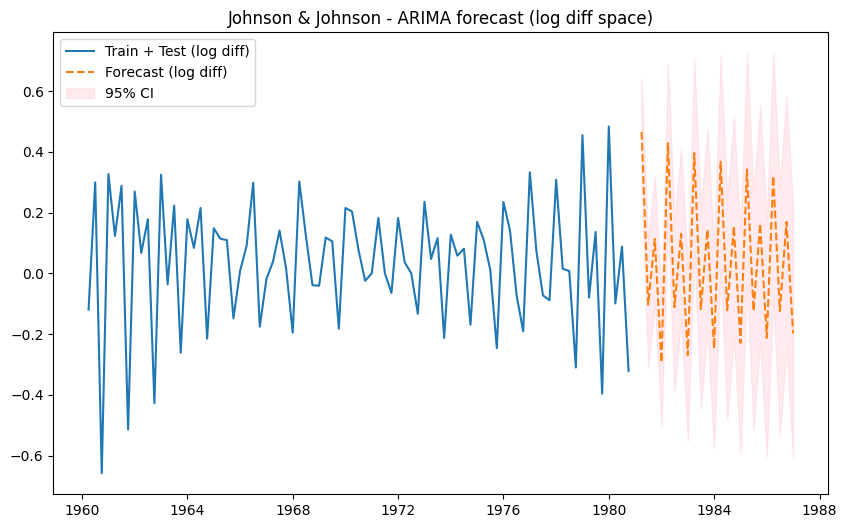

In [33]:
# For demonstration, let's just plot the differenced forecast:
plt.figure()
plt.plot(jj_log_diff.index, jj_log_diff, label="Train + Test (log diff)")
forecast_index = pd.date_range(start=jj_log_diff.index[-1], periods=forecast_steps+1, freq='Q')[1:]
# ^ Adjust freq as needed (monthly vs quarterly etc.)

plt.plot(forecast_index, mean_forecast, label="Forecast (log diff)", linestyle="--")
plt.fill_between(forecast_index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='pink', alpha=0.3, label="95% CI")

plt.title("Johnson & Johnson - ARIMA forecast (log diff space)")
plt.legend()
plt.show()

**4. Forecasting with the Neural Network**
To forecast 24 months ahead, we use a recursive (iterative) strategy. Starting from the last observed window, predict one value at a time and append it to the window for subsequent predictions.

In [35]:
# ===========================
#   8. AMAZON MODELING (Manual ARIMA)
# ===========================

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Use the log-differenced close price (already done previously)
amzn_close_log_diff = amzn_log_diff.dropna()

# Split data into training and test sets
n_test_amzn = 50  # e.g. last 50 days for testing
train_amzn = amzn_close_log_diff.iloc[:-n_test_amzn]
test_amzn = amzn_close_log_diff.iloc[-n_test_amzn:]

# Manual Grid Search for ARIMA(p,d,q)
import itertools

p_values = range(0, 5)
d_values = [0, 1]  # Already differenced once externally, but still allow d=1 for flexibility
q_values = range(0, 5)

best_aic = float("inf")
best_order = None
best_model_amzn = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_amzn, order=(p,d,q))
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = (p,d,q)
            best_model_amzn = model_fit
    except:
        continue

print(f"Best ARIMA order for Amazon Close: {best_order} with AIC: {best_aic}")
print(best_model_amzn.summary())

Best ARIMA order for Amazon Close: (0, 0, 0) with AIC: -5720.300917839384
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1208
Model:                          ARIMA   Log Likelihood                2862.150
Date:                Sat, 12 Apr 2025   AIC                          -5720.301
Time:                        18:10:59   BIC                          -5710.107
Sample:                             0   HQIC                         -5716.462
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.226      0.821      -0.001       0.001
sigma2         0.0005   1.18e-05     43.411      0.000   

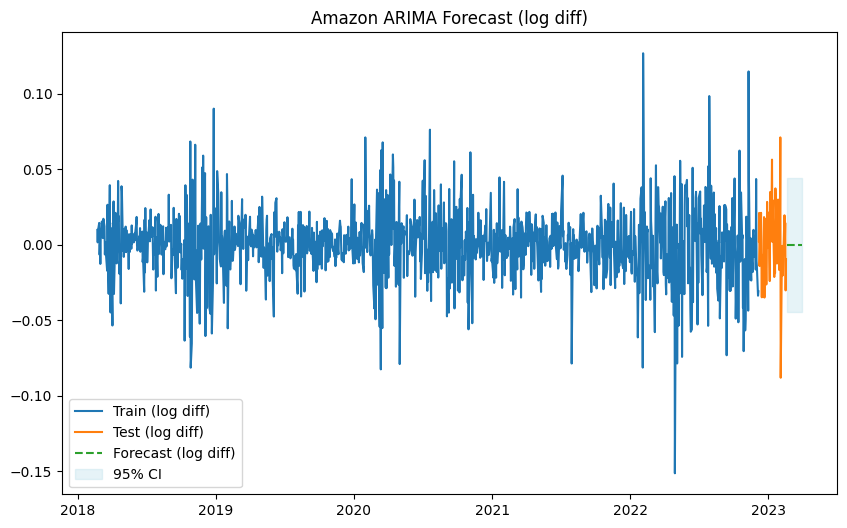

In [37]:
# Forecast using the best model
forecast_steps_amzn = 30
amzn_fc = best_model_amzn.get_forecast(steps=forecast_steps_amzn)
amzn_mean_fc = amzn_fc.predicted_mean
amzn_conf_int = amzn_fc.conf_int()

# Plot forecast in differenced log space (again, you'd invert this for real-scale):
plt.figure()
plt.plot(train_amzn.index, train_amzn, label="Train (log diff)")
plt.plot(test_amzn.index, test_amzn, label="Test (log diff)")
forecast_idx = pd.date_range(start=test_amzn.index[-1], periods=forecast_steps_amzn+1, freq='B')[1:]
plt.plot(forecast_idx, amzn_mean_fc, label="Forecast (log diff)", linestyle="--")
plt.fill_between(forecast_idx,
                 amzn_conf_int.iloc[:, 0],
                 amzn_conf_int.iloc[:, 1],
                 color='lightblue', alpha=0.3, label="95% CI")
plt.title("Amazon ARIMA Forecast (log diff)")
plt.legend()
plt.show()

In [38]:
# ===========================
#   9. BASIC NEURAL NETWORK EXAMPLE (Part 2)
# ===========================
# For a neural network approach, you can e.g. create a simple MLP or LSTM
# to forecast time series. Below is a minimal example with a feed-forward MLP on J&J data.

# 9.1 Prepare data (Supervised approach, shift by 1, etc.)
jj_data = jj_df["sales"].values.reshape(-1,1).astype(float)

# Scale data
scaler = MinMaxScaler()
jj_scaled = scaler.fit_transform(jj_data)

# Let's build a supervised dataset for a one-step ahead forecast
def make_supervised(series, n_lag=1):
    X, y = [], []
    for i in range(len(series)-n_lag):
        X.append(series[i:i+n_lag, 0])
        y.append(series[i+n_lag, 0])
    return np.array(X), np.array(y)

n_lag = 1
X_jj, y_jj = make_supervised(jj_scaled, n_lag=n_lag)

# Train/test split
split_idx = int(len(X_jj)*0.8)
X_train_jj, X_test_jj = X_jj[:split_idx], X_jj[split_idx:]
y_train_jj, y_test_jj = y_jj[:split_idx], y_jj[split_idx:]

In [39]:
# 9.2 Define a simple MLP model
model_mlp = Sequential()
model_mlp.add(Dense(16, activation='relu', input_shape=(n_lag,)))
model_mlp.add(Dense(8, activation='relu'))
model_mlp.add(Dense(1, activation='linear'))

model_mlp.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model_mlp.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0262 - val_loss: 0.0753
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0098 - val_loss: 0.0901
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054 - val_loss: 0.0326
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0019 - val_loss: 0.0352
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0390
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016 - val_loss: 0.0344
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 0.0378
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0359
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0351
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.2129e-04 - val_loss: 0.0351
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0316
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.03

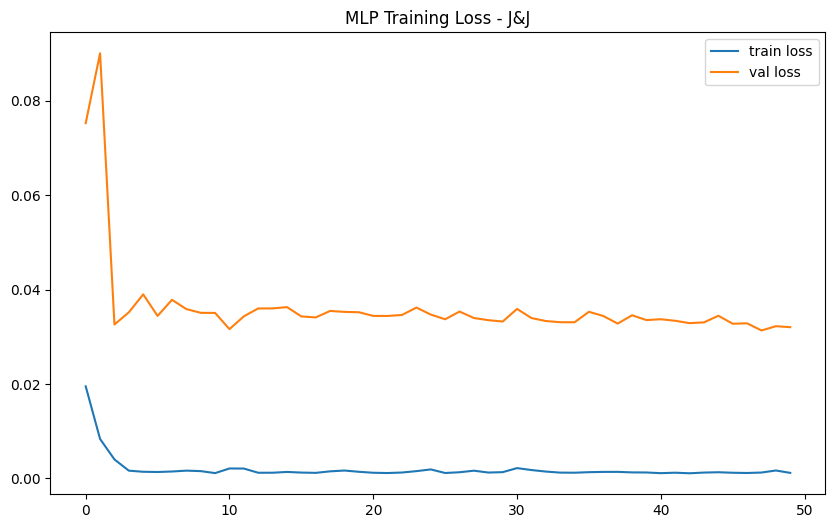

In [40]:
# 9.3 Train the model
history = model_mlp.fit(
    X_train_jj, y_train_jj,
    validation_data=(X_test_jj, y_test_jj),
    epochs=50, batch_size=8, verbose=1
)

# Plot training history
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("MLP Training Loss - J&J")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


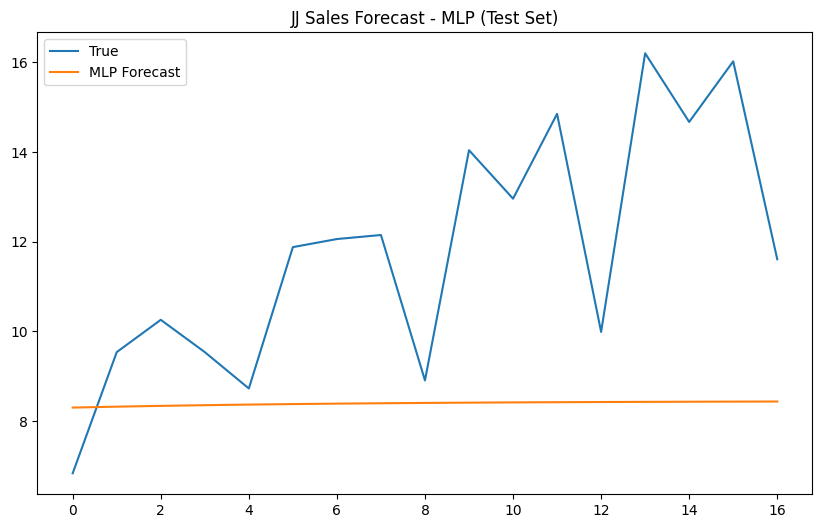

In [41]:
# 9.4 Forecasting with the MLP (one-step ahead recursively)
predictions = []
last_n = X_test_jj[0]  # first test sample
for i in range(len(X_test_jj)):
    next_pred = model_mlp.predict(last_n.reshape(1,-1))[0][0]
    predictions.append(next_pred)
    # shift window
    last_n = np.roll(last_n, -1)
    last_n[-1] = next_pred

predictions = np.array(predictions)

# Invert scale
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test_jj.reshape(-1,1))

plt.figure()
plt.plot(y_test_rescaled, label='True')
plt.plot(predictions_rescaled, label='MLP Forecast')
plt.title("JJ Sales Forecast - MLP (Test Set)")
plt.legend()
plt.show()
